In [1]:
# import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [12]:
def bridge_network():
    """
    returns a multi directed graph which includes bridges and intersections between roads
    """
    # import data
    df = pd.read_csv('../data/bridges_cleaned.csv')
    # for now we use N1 and N2 only, roads with intersections excluded
    # TODO import database with roads with intersections too, for all rows
    df = df[(df['road']=='N1')]
    # only get first few rows
    df = df[0:5]
    # drop old column named index
    df = df.drop("index", axis='columns')

    # sort roads dataframe based on road name and chainage
    df = df.sort_values(by=['road', 'km'])
    # reset index
    df = df.reset_index(drop=True)
    # rename
    df.rename({'Unnamed: 0': 'index'}, axis=1, inplace=True)
    # retrieve all roads in dataset
    roads = df['road'].unique().tolist()

    G= nx.MultiDiGraph()
    # for each road in list roads
    for road in roads: 
        # subset all data points for the road
        road_subset = df[df['road'] == road]
        for index, row in road_subset.iterrows():
            G.add_node(row['index'], pos = (row['lat'], row['lon']))
            # retrieve all edges between bridges for one road
        edges = [(index, index+1) for index, row in road_subset.iterrows()]
        # remove last one, which is out of bound
        edges.pop()
        # reverse subset
        road_subset_reversed = road_subset.iloc[::-1]
        # get all reversed indexes and add to list of edges
        edges += [(index, index-1) for index, row in road_subset_reversed.iterrows()]
        # remove last one, which is out of bound
        edges.pop()
        # add all edges 
        G.add_edges_from(edges)   
        
           
    for u,v,k in G.edges: 
        # obtain distance between nodes
        distance = abs((road_subset.iloc[u, road_subset.columns.get_indexer(['km'])].values) - 
                       (road_subset.iloc[v, road_subset.columns.get_indexer(['km'])].values))
        # from kilometers to meters
        distance = distance * 1000 
        # assign distance as weight to edge
        G[u][v][k]['weight'] = distance
    
    # return network
    return G

In [4]:
def intersection_network(): 
    """
    returns a multi directed graph which only includes intersections
    """
    # import data
    df = pd.read_csv('../data/bridges_cleaned.csv')
    # for now we use N1 and N2 only, roads with intersections excluded
    # TODO import database with roads with intersections too, for all rows
    df = df[(df['road']=='N1')]
    # only get first few rows
    df = df[0:5]
    # drop old column named index
    df = df.drop("index", axis='columns')

    # sort roads dataframe based on road name and chainage
    df = df.sort_values(by=['road', 'km'])
    # reset index
    df = df.reset_index(drop=True)
    # rename
    df.rename({'Unnamed: 0': 'index'}, axis=1, inplace=True)
    # retrieve all roads in dataset
    roads = df['road'].unique().tolist()
    
    G= nx.MultiDiGraph()
    # for each road in list roads
    for road in roads: 
        # subset all data points for the road
        road_subset = df[df['road'] == road]
        for index, row in road_subset.iterrows():
            # if row is an intersection
            if row['model_type'] == 'intersection': 
                # add node to graph
                G.add_node(row['index'], pos = (row['lat'], row['lon']))
        # retrieve all edges between intersections for one road
        edges = [(index, index+1) for index, row in road_subset.iterrows()]
        # remove last one, which is out of bound
        edges.pop()
        # reverse subset
        road_subset_reversed = road_subset.iloc[::-1]
        # get all reversed indexes and add to list of edges
        edges += [(index, index-1) for index, row in road_subset_reversed.iterrows()]
        # remove last one, which is out of bound
        edges.pop()
        # add all edges 
        G.add_edges_from(edges)   
        
    # TODO how to compute distance between intersections, use column with cumulative sum? 
    for u,v,k in G.edges: 
        distance = abs((road_subset.iloc[u, road_subset.columns.get_indexer(['km'])].values) - 
                       (road_subset.iloc[v, road_subset.columns.get_indexer(['km'])].values))
        # from kilometers to meters
        distance = distance * 1000 
        G[u][v][k]['weight'] = distance
    
    # return network
    return G

In [17]:
def visualize_graph(visual = 'bridges'): 
    if visual == 'bridges': 
        # call network
        network = bridge_network()
    elif visual == 'intersections': 
        # call network
        network = intersection_network()
        
    # get position of nodes
    pos = nx.get_node_attributes(network, 'pos')
    # draw network based on position
    nx.draw(network, pos, with_labels=True, connectionstyle='arc3, rad = 0.1')
    # show plot
    plt.show()

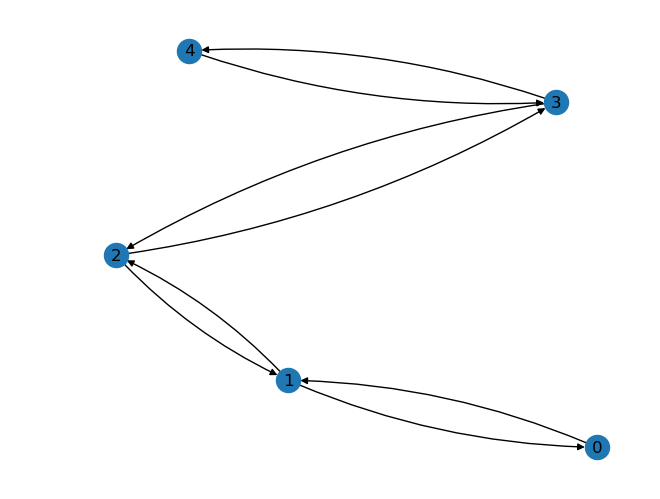

In [18]:
visualize_graph('bridges')

In [25]:
def get_shortest_path(origin, destination):
    """
    gives the shortest path between an origin and destination, 
    based on bridge network defined using NetworkX library, 
    and adds tihis path to path_ids_dict
    """

    # call network
    #TODO make network a model attribute?
    network = bridge_network()
    #first, check if there already is a shortest path:
    # TODO add shortest_path_dict to model attributes
    if key in self.shortest_path_dict.keys():
        return self.shortest_path_dict[source, sink]
    else:
        # compute shortest path between origin and destination based on distance (which is weight)
        shortest_path = nx.shortest_path(network, origin, destination, weight='weight')
        # format shortest path in dictionary structure
        self.shortest_path_dict[origin, destination] = shortest_path
        return self.shortest_path_dict[source, sink]
        # test to see shortest path in dictionary structure
        #return self.shortest_path_dict

In [26]:
get_shortest_path(origin = 2, destination = 4)

{(2, 4): [2, 3, 4]}

# TODO modify methods so that get shortest path method is also included
# if shortest path already in path_ids_dict, don't compute shortest path again and just take it
# else compute shortest path using get shortest path method
def get_random_route(self, source):
    """
    pick up a random route given an origin
    """
    while True:
        # different source and sink
        sink = self.random.choice(self.sinks)
        if sink is not source:
            break
    return self.path_ids_dict[source, sink]

def get_straight_route(self, source):
    """
    pick up a straight route given an origin
    """
    return self.path_ids_dict[source, None]

# TODO change default straight route, include random route method too
def get_route(self, source):
    return self.get_straight_route(source)